In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import *
import copy
# from copy import 




In [168]:

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [190]:
# Load dataset without any normalization
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Compute mean and std
data = torch.cat([img for img, _ in train_dataset], dim=0)
mean = torch.mean(data)
std = torch.std(data)

# Now, define the transform with computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with normalization
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [289]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50, bias=False)
        self.bn1 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 40, bias=False)
        self.bn2 = nn.BatchNorm1d(40)
        self.fc3 = nn.Linear(40, 30, bias=False)
        self.bn3 = nn.BatchNorm1d(30)
        self.fc4 = nn.Linear(30, 10, bias=False)
        self.bn4 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.bn4(F.relu(self.fc4(x)))
        return F.log_softmax(x, dim=1)

In [290]:
# Functions
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total


def evaluate_and_prune(model, test_loader, prune_step=50):
    # To store accuracies for each level of pruning
    accuracies = []
    
    # Clone the original model, so the original model remains unaffected
    model_copy = copy.deepcopy(model)
    
    # Create a list to hold all weights and their respective parameter tensor and index
    weight_info = []
    
    for param in model_copy.parameters():
        flattened_param = param.view(-1)
        for idx, w in enumerate(flattened_param):
            weight_info.append((w.item(), param, idx))
            
   
    # Sort the weight info list by the absolute value of the weights
    weight_info.sort(key=lambda x: abs(x[0]))
    
    # Loop to prune weights in steps and evaluate the model
    for i in tqdm(range(0, len(weight_info), prune_step)):
        # Zero out the smallest weights
        with torch.no_grad():
            for _, param, idx in weight_info[i:i+prune_step]:
                param.view(-1)[idx] = 0.0
        
        # Evaluate the accuracy of the pruned model
        accuracy = evaluate_accuracy(model_copy, test_loader)
        accuracies.append(accuracy)

    return accuracies

def get_sorted_weights(model):
    sorted_weights = []
    for param in model.parameters():
        sorted_weights.extend(torch.abs(param.detach()).cpu().numpy().flatten())
    sorted_weights = sorted(sorted_weights)
    return sorted_weights





In [291]:
def train_model(optimizer_type,weight_decay=0, lr=0.00001, num_epochs = 20):
    model = SimpleNN()
    torch.manual_seed(0)
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'AdamL1':
        optimizer = optim.Adam(model.parameters(), lr=lr)  
    else:
        raise ValueError("Invalid optimizer type")

    criterion = nn.CrossEntropyLoss()

    # Capture initial weights before training
    initial_weights = []
    for param in model.parameters():
        initial_weights.extend(torch.abs(param.detach()).cpu().numpy().flatten())
    initial_weights = sorted(initial_weights)


    loss_list = []
    accuracy_list = []  # New list to keep track of accuracy
    for epoch in tqdm(range(num_epochs)):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            if optimizer_type == 'AdamL1':
                l1_lambda = weight_decay
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
                
            loss.backward()
            optimizer.step()

        # Validation loss (Raw loss, without regularization)
        val_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()

        loss_list.append(val_loss / len(test_loader))
        
        # Use evaluate_accuracy function to calculate accuracy
        accuracy = evaluate_accuracy(model, test_loader)
        accuracy_list.append(accuracy)
        
    return loss_list, accuracy_list, model



In [292]:
epochs=100
# Training and getting losses and weights
adam_loss_0, adam_accuracy_0, adam_model_0 = train_model('Adam',num_epochs=epochs, lr=0.0001)
adamL2_loss, adamL2_accuracy, adamL2_model = train_model('Adam',weight_decay=0.02,num_epochs=epochs, lr=0.0001)
adamW_loss, adamW_accuracy, adamW_model = train_model('AdamW',weight_decay=0.02,num_epochs=epochs, lr=0.0001)
adamL1_loss, adamL1_accuracy, adamL1_model = train_model('AdamL1',weight_decay=0.002,num_epochs=epochs, lr=0.0001)





  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:06<00:00,  5.46s/it]


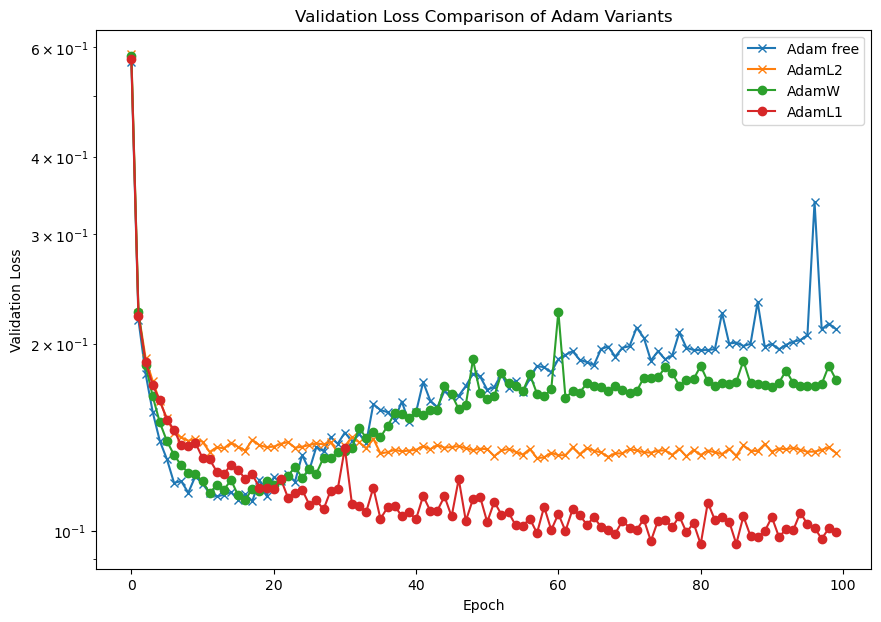

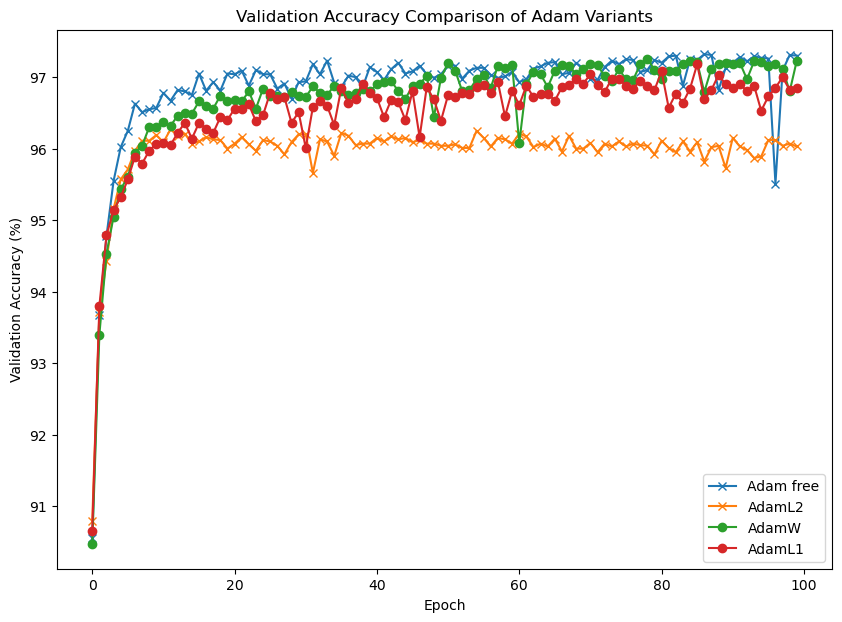

In [293]:
# Plotting the loss
plt.figure(figsize=(10, 7))
plt.plot(adam_loss_0, '-x', label='Adam free')
plt.plot(adamL2_loss, '-x', label='AdamL2')
plt.plot(adamW_loss, '-o', label='AdamW')
plt.plot(adamL1_loss, '-o', label='AdamL1')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.yscale('log')
plt.title('Validation Loss Comparison of Adam Variants')
plt.show()



# Plotting the accuracy
plt.figure(figsize=(10, 7))
plt.plot(adam_accuracy_0, '-x', label='Adam free')
plt.plot(adamL2_accuracy, '-x', label='AdamL2')
plt.plot(adamW_accuracy, '-o', label='AdamW')
plt.plot(adamL1_accuracy, '-o', label='AdamL1')


plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison of Adam Variants')
plt.show()

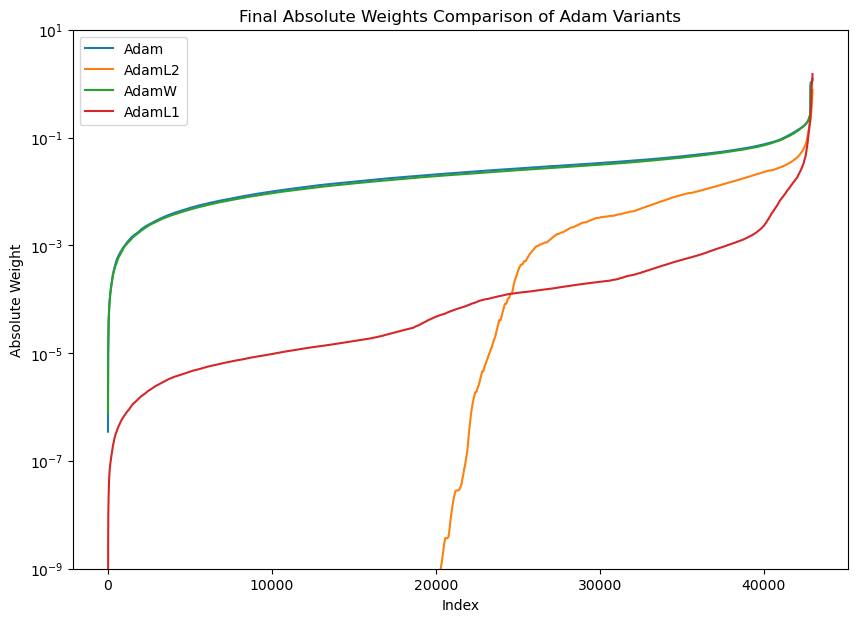

In [295]:
# Plotting the final sorted absolute weights
plt.figure(figsize=(10, 7))
# plt.semilogy(adam_final_weights_0, label='Adam free Final')
plt.semilogy(get_sorted_weights(adam_model_0), label='Adam')
plt.semilogy(get_sorted_weights(adamL2_model), label='AdamL2')
plt.semilogy(get_sorted_weights(adamW_model), label='AdamW')
plt.semilogy(get_sorted_weights(adamL1_model), label='AdamL1')

plt.xlabel('Index')
plt.ylabel('Absolute Weight')
plt.legend()
plt.title('Final Absolute Weights Comparison of Adam Variants')
plt.ylim(1e-9, 1e1)
plt.show()

In [298]:
prune_step = 300
adam_accuracies = evaluate_and_prune(adam_model_0, test_loader,prune_step=prune_step)
adamL2_accuracies = evaluate_and_prune(adamL2_model, test_loader,prune_step=prune_step)
adamW_accuracies = evaluate_and_prune(adamW_model, test_loader,prune_step=prune_step)
adamL1_accuracies = evaluate_and_prune(adamL1_model, test_loader,prune_step=prune_step)


100%|██████████| 144/144 [01:09<00:00,  2.07it/s]


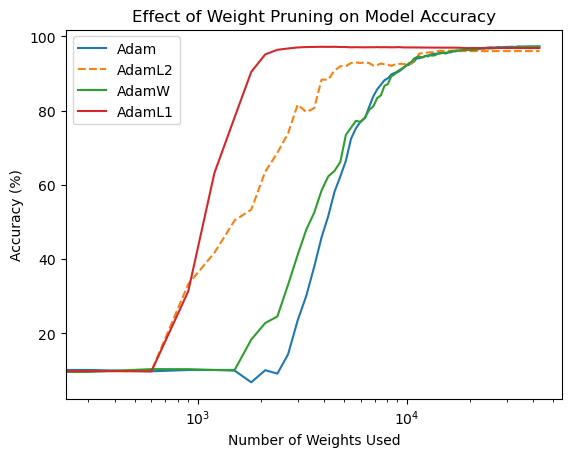

In [299]:

x_values = [i*prune_step for i in range(len(adam_accuracies))]

# Plotting
plt.semilogx(x_values, adam_accuracies[::-1], label='Adam')
plt.plot(x_values, adamL2_accuracies[::-1], label='AdamL2',ls='--')
plt.plot(x_values, adamW_accuracies[::-1], label='AdamW')
plt.plot(x_values, adamL1_accuracies[::-1], label='AdamL1')


plt.xlabel('Number of Weights Used')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Weight Pruning on Model Accuracy')
plt.legend()
plt.show()

In [ ]:
def evaluate_accuracy_on_inverted(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            inverted_data = -data  # negate the tensor to invert the color
            output = model(inverted_data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

accuracy_on_inverted = evaluate_accuracy_on_inverted(model, test_loader)
print(f'Accuracy on inverted data: {accuracy_on_inverted}%')


In [213]:
torch.tensor(adam_final_weights).pow(2).sum()*0.002,torch.tensor(adamL1_final_weights).abs().sum()*0.002

(tensor(0.0491), tensor(0.0658))

# Older thing, will get back to this

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # added another hidden layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # added ReLU activation here
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Parameters
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.01  # Regularization strength for both Adam and AdamW
HIDDEN_DIM = 128
INPUT_DIM = 28*28
OUTPUT_DIM = 10

# Load Data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

# Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Adam Optimizer with L2 regularization
optimizer_adam = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# AdamW Optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Train using Adam with L2 regularization
for epoch in trange(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer_adam, epoch)

# (Optional) Reset the model weights here if you want separate runs

# Train using AdamW
for epoch in trange(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer_adamw, epoch)

# (Optional) Evaluation, plots, etc.


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:04<00:00,  2.15s/it]


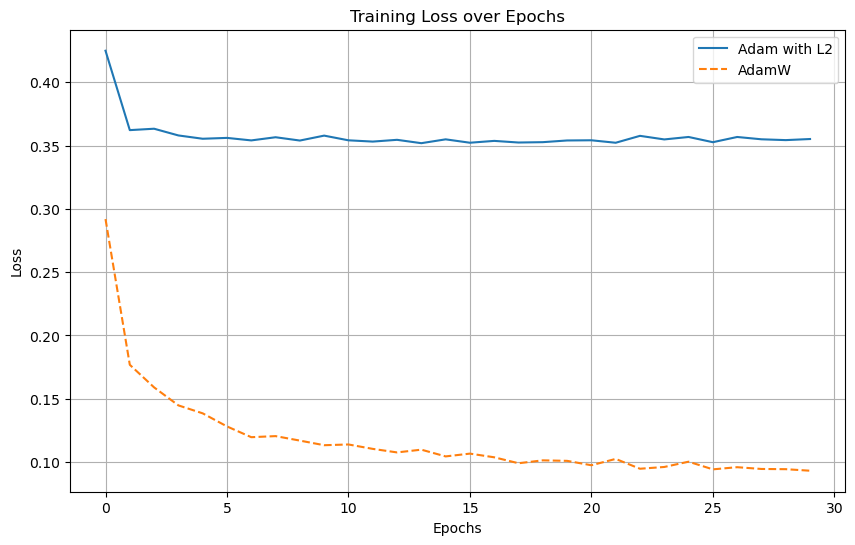

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Plotting function
def plot_losses(adam_losses, adamw_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(adam_losses, label='Adam with L2', linestyle='-')
    plt.plot(adamw_losses, label='AdamW', linestyle='--')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.01
WEIGHT_DECAY = 0.01
HIDDEN_DIM = 30
INPUT_DIM = 28*28
OUTPUT_DIM = 10

# Load Data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Adam Optimizer with L2 regularization
optimizer_adam = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# AdamW Optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Lists to store average loss per epoch
adam_losses = []
adamw_losses = []

# Train using Adam with L2 regularization
model_copy = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)  # Copy of the initial model weights
model_copy.load_state_dict(model.state_dict())

for epoch in trange(EPOCHS):
    
    loss = train(model, device, train_loader, optimizer_adam)
    adam_losses.append(loss)

# Load the original weights for training with AdamW
model.load_state_dict(model_copy.state_dict())

for epoch in trange(EPOCHS):
    loss = train(model, device, train_loader, optimizer_adamw)
    adamw_losses.append(loss)

plot_losses(adam_losses, adamw_losses)
